# Analysis of different latent spaces for the autoencoder model
We use as the input data images from the first 2 months of 2016 because of the number of times we will have to train and evaluate our model

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import sunpy.map
import cv2
import skimage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem

2023-03-15 09:13:29.009432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading data and removing noise

In [2]:
# Read images
AIA193_2016 = sunpy.map.Map(["data/aia_193A/2016-01*.fits", "data/aia_193A/2016-02*.fits"])
AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))


# Normalize images
min_values = AIA193_2016_matrix.min(axis=2).min(axis=1)
max_values = AIA193_2016_matrix.max(axis=2).max(axis=1)

rg = max_values - min_values
rg = np.maximum(rg, 1e-4*np.ones(rg.shape)).reshape([-1,1,1])

AIA193_2016_mnorm = (AIA193_2016_matrix-min_values.reshape([-1,1,1])) / rg


input_train, input_test = train_test_split(AIA193_2016_mnorm, test_size=0.2)
print(f"number of images used: {len(AIA193_2016_mnorm)}")
print(f"for training: {len(input_train)}")
print(f"for testing: {len(input_test)}")

number of images used: 474
for training: 379
for testing: 95


## Train and discard autoencoders with different latent space sizes

In [3]:
latent_size = 64
n_epochs = 200
batch_size = 128

k_search = np.concatenate([np.arange(1, 16, 2), np.arange(16, 64, 4), np.arange(64, 256, 16), np.arange(256, 1024, 32), [1024]])

for i in range(7):
    mse_values = []
    for k in k_search:
        print(f"\nStarting training for k={k}")
        autoencoder, _, _ = aem.gen_autoenc_model(k, optim="adam", loss="mse", verbose=False)
        autoencoder.fit(input_train.reshape([-1, 256,256,1]), input_train.reshape([-1, 256,256,1]), validation_split=0.2, epochs=n_epochs, batch_size=batch_size, verbose=False)

        print(f"Finished training for k={k}")

        mse_value = autoencoder.evaluate(input_test.reshape([-1, 256,256,1]), input_test.reshape([-1, 256,256,1]))[0]
        mse_value_array = np.array(mse_value)
        mse_values.append(mse_value)

        del autoencoder
        del mse_value

    pd.DataFrame({"Latent":k_search, "MSE":mse_values}).to_csv(f"knee_AE{i}.csv", index=False)


Starting training for k=1


2023-03-15 09:13:34.392823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 09:13:34.491580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 09:13:34.491746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 09:13:34.492321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow w

Finished training for k=1
3/3 [==============================] - 1s 196ms/step - loss: 0.0035 - mae: 0.0342

Starting training for k=3
Finished training for k=3
3/3 [==============================] - 0s 8ms/step - loss: 0.0033 - mae: 0.0293

Starting training for k=5
Finished training for k=5
3/3 [==============================] - 0s 8ms/step - loss: 0.0030 - mae: 0.0298

Starting training for k=7
Finished training for k=7
3/3 [==============================] - 0s 8ms/step - loss: 0.0032 - mae: 0.0292

Starting training for k=9
Finished training for k=9
3/3 [==============================] - 0s 9ms/step - loss: 0.0035 - mae: 0.0281

Starting training for k=11
Finished training for k=11
3/3 [==============================] - 0s 9ms/step - loss: 0.0031 - mae: 0.0328

Starting training for k=13
Finished training for k=13
3/3 [==============================] - 0s 9ms/step - loss: 0.0032 - mae: 0.0294

Starting training for k=15
Finished training for k=15
3/3 [==============================

KeyboardInterrupt: 

## Get graph

In [18]:
collected_data_files = [
    "knee_AE0.csv",
    "knee_AE1.csv",
    "knee_AE2.csv",
    "knee_AE3.csv",
    "knee_AE4.csv",
    "knee_AE5.csv",
    "knee_AE6.csv",
    "knee_AE7.csv"
]


#collected_data = pd.read_csv("knee_AE0.csv")
#collected_data = collected_data.drop(columns=["MSE"])
collected_data = pd.DataFrame(columns=["Latent", "MSE", "exec"])
for idx, data_file in enumerate(collected_data_files):
    df = pd.read_csv(data_file)
    df["exec"] = idx
    collected_data = pd.concat(df["MSE"])


#collected_data["MSE"] /= len(collected_data_files)
collected_data

,Latent,MSE0,MSE1,MSE2,MSE3,MSE4,MSE5,MSE6,MSE7
0,1,0.003483,0.003172,0.003481,0.022536,0.003059,0.003221,0.022447,0.003386
1,3,0.003320,0.022495,0.022423,0.022474,0.003838,0.022478,0.003455,0.022965
2,5,0.003020,0.022416,0.022456,0.022405,0.022548,0.003458,0.022492,0.022924
3,7,0.003217,0.003415,0.003298,0.003251,0.003458,0.003029,0.006005,0.003636
4,9,0.003532,0.003005,0.003377,0.004097,0.003184,0.002849,0.003340,0.003374
5,11,0.003117,0.003212,0.003084,0.022428,0.004130,0.003575,0.003369,0.003791
6,13,0.003183,0.003099,0.003220,0.003029,0.022473,0.003440,0.022652,0.003388
7,15,0.003545,0.002989,0.003109,0.022472,0.002887,0.003317,0.003044,0.003040
8,16,0.003514,0.003022,0.003032,0.003076,0.003216,0.003293,0.003765,0.003329
9,20,0.023791,0.003061,0.002941,0.002715,0.003300,0.002863,0.002848,0.003091


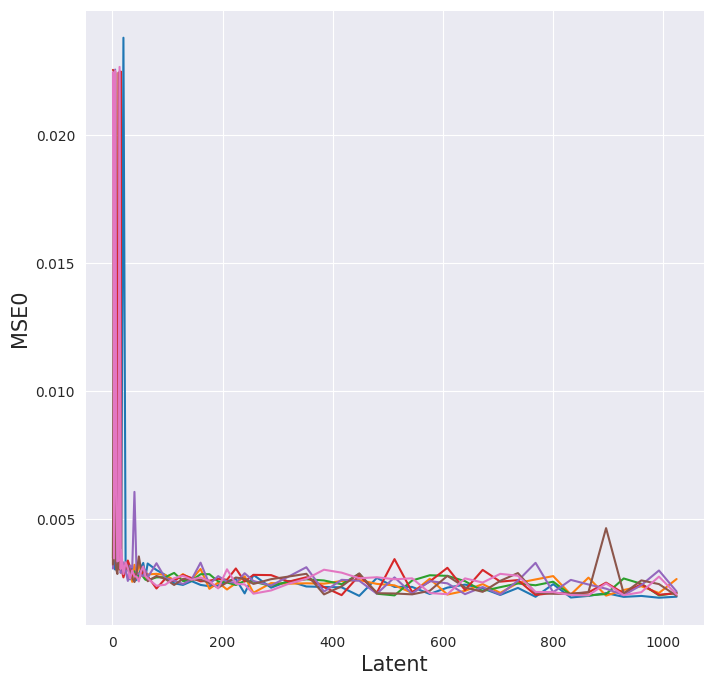

In [38]:
fig, axes = plt.subplots(1, figsize=(8,8)) 

for col in [f"MSE{i}" for i in range(7)]:
    sns.lineplot(collected_data, x="Latent", y=col)

<AxesSubplot: xlabel='Latent', ylabel='MSE0'>

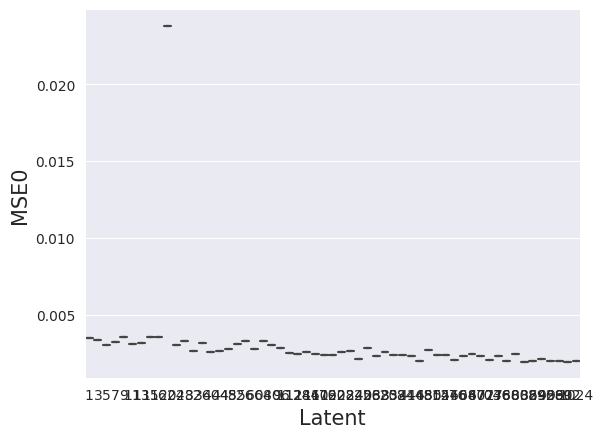

In [39]:
sns.boxplot(collected_data, x="Latent", y="MSE0")

In [ ]:
fig, axes = plt.subplots(1, figsize=(8,8)) 
lineplot = sns.lineplot(collected_data, x="Latent", y="MSE", ax=axes)
lineplot.set(xticks=range(0,1024,32))
lineplot.set_xticklabels(axes.get_xticklabels(), rotation=-75)

plt.show()